## Introduction

This exercise uses the data from Kaggle's [Sentiment Analysis](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) competition.

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. 

In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. 

This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

## Acknowledgements

[1] Pang and L. Lee. 2005. Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales. In ACL, pages 115–124.

[2] Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank, Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Chris Manning, Andrew Ng and Chris Potts. Conference on Empirical Methods in Natural Language Processing (EMNLP 2013).

## Datasets

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

- train.tsv : contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
- test.tsv : contains just phrases. You must assign a sentiment label to each phrase.
- The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

## Evaluation

Submissions are evaluated on **classification accuracy (the percent of labels that are predicted correctly)** for every parsed phrase. The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
4 - positive

## Submission Format

For each phrase in the test set, predict a label for the sentiment. Your submission should have a header and look like the following:

#### PhraseId,Sentiment
- 156061,2
- 156062,2
- 156063,2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_table('/Users/debajyotidas/Documents/GitHub/Rotten Tomatoes review Sentiment Analysis/Data/train.tsv.zip',
                    header=None,names=['PhraseId','SentenceId','Phrase','Sentiment'],sep='\t')

In [3]:
data.shape

(156061, 4)

In [4]:
data.sample(n=5)

,PhraseId,SentenceId,Phrase,Sentiment
122810,122810,6587,the travail,2
71852,71852,3667,", writer-director Michael Kalesniko 's How to ...",1
75276,75276,3862,quirks,2
150175,150175,8180,'ll love it and,4
65731,65731,3332,", this is the ultimate movie experience",4


In [5]:
data.drop(columns=['PhraseId','SentenceId'])

,Phrase,Sentiment
0,Phrase,Sentiment
1,A series of escapades demonstrating the adage ...,1
2,A series of escapades demonstrating the adage ...,2
3,A series,2
4,A,2
...,...,...
156056,Hearst 's,2
156057,forced avuncular chortles,1
156058,avuncular chortles,3
156059,avuncular,2


In [6]:
data['Sentiment'].value_counts()

2            67352
3            27634
1            22492
2            12230
4             7665
0             5928
3             5293
1             4781
4             1541
0             1144
Sentiment        1
Name: Sentiment, dtype: int64

In [7]:
#Dropping one odd sentiment stored as text
data.drop(data[data['Sentiment']=='Sentiment'].index,inplace=True)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# split X and y into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data.Phrase, data.Sentiment, random_state=42)

In [10]:
#Traing data
print(x_train.shape)
print(y_train.shape)

(117045,)
(117045,)


In [11]:
#Test Data
print(x_test.shape)
print(y_test.shape)

(39015,)
(39015,)


In [12]:
x_train.sample(n=5)

122294    wisely decided to let Crocodile Hunter Steve I...
104865     forced drama in this wildly uneven movie , about
35744                                 if you need to see it
106043                                                risky
129877         its material that is deliberately unsettling
Name: Phrase, dtype: object

In [13]:
#Converting the dependent variable as Integer, so as to be able to use it in Deep Learning
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [14]:
y_train.value_counts()

2    59947
3    24543
1    20419
4     6804
0     5332
Name: Sentiment, dtype: int64

In [15]:
import re
from bs4 import BeautifulSoup

In [16]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [17]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [18]:
class PreProcessor:
    def __call__(self, doc):
        soup = BeautifulSoup(doc, "html.parser")
        stripped_text = soup.get_text()
        #Using regex
        text = re.sub(r'[^a-zA-z\s]', '', stripped_text)
        return text

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',preprocessor=PreProcessor(),tokenizer=LemmaTokenizer(),ngram_range=(1, 5),max_df=0.2,min_df=2,max_features=50000)

In [20]:
X_train_tfidf = tfidf.fit_transform(x_train)

In [21]:
len(tfidf.vocabulary_)

50000

In [22]:
X_train_tfidf.shape

(117045, 50000)

In [23]:
X_test_tfidf = tfidf.transform(x_test)

In [24]:
from sklearn.naive_bayes import MultinomialNB

In [25]:
#instantiate the model (with the default parameters)
mnb = MultinomialNB()

#fit the model with data (occurs in-place)
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [26]:
from sklearn import metrics

In [27]:
print ('Training accuracy of MultinomialNB using CountVectorizer',metrics.accuracy_score(y_train, mnb.predict(X_train_tfidf)))

Training accuracy of MultinomialNB using CountVectorizer 0.6554658464693067


In [28]:
print ('Testing accuracy of MultinomialNB using CountVectorizer',metrics.accuracy_score(y_test, mnb.predict(X_test_tfidf)))

Testing accuracy of MultinomialNB using CountVectorizer 0.5898756888376265


In [29]:
cr=metrics.classification_report(y_test,mnb.predict(X_test_tfidf))
print(cr)

              precision    recall  f1-score   support

           0       0.55      0.08      0.14      1740
           1       0.53      0.25      0.34      6854
           2       0.60      0.91      0.73     19635
           3       0.55      0.37      0.44      8384
           4       0.60      0.08      0.14      2402

    accuracy                           0.59     39015
   macro avg       0.57      0.34      0.36     39015
weighted avg       0.58      0.59      0.54     39015



Let us use **Glove** embeddings to see if we can improve the accuracy

In [30]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [31]:
y_train = tf.keras.utils.to_categorical(y_train,5)
y_test = tf.keras.utils.to_categorical(y_test,5)

In [32]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000) # num_words -> Vocablury size

In [33]:
#Fit tokenizer with actual training data
tokenizer.fit_on_texts(x_train.tolist())

In [34]:
#Replace each word in the text with word's index
X_train = tokenizer.texts_to_sequences(x_train.tolist())

In [35]:
X_test = tokenizer.texts_to_sequences(x_test)

In [36]:
len(X_train[0])

3

In [37]:
#Define maximum number of words to consider in each review
max_review_length = 50

In [38]:
#Pad training and test reviews
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        maxlen=max_review_length,
                                                        padding='pre',
                                                        truncating='pre')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                       maxlen=max_review_length, 
                                                       padding='pre',
                                                       truncating='pre')

In [39]:
import gensim.downloader as api

In [40]:
glove=api.load('glove-wiki-gigaword-50')

In [41]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = glove.vector_size
desired_vocab_size=50000

In [42]:
#Initialize embedding matrix for our dataset with 10000+1 rows (1 for padding word)
#and 50 columns (as embedding size is 50)
embedding_matrix = np.zeros((desired_vocab_size + 1, embedding_vector_length))

In [43]:
for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (desired_vocab_size+1):
        break
    try:
        embedding_vector = glove[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [44]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(desired_vocab_size + 1, 
                                    embedding_vector_length, 
                                    weights=[embedding_matrix], 
                                    trainable=False, 
                                    input_length=max_review_length))

In [45]:
#Add first convolutional layer with 32 kernels
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3),strides=1))
#normalize data
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
#Add second convolutional layer with 64 kernels
model.add(tf.keras.layers.Conv1D(64, kernel_size=(3), strides=2))
#normalize data
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

In [46]:
#Use Global Average Pooling
model.add(tf.keras.layers.GlobalMaxPooling1D())

#Output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            2500050   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 32)            4832      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 32)            128       
_________________________________________________________________
re_lu (ReLU)                 (None, 48, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 64)            6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 64)            256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 23, 64)            0

In [47]:
#Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [48]:
hist_glove=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test))

Epoch 1/10
3658/3658 [==============================] - 29s 8ms/step - loss: 1.1331 - accuracy: 0.5528 - val_loss: 1.0591 - val_accuracy: 0.5754
Epoch 2/10
3658/3658 [==============================] - 29s 8ms/step - loss: 1.0465 - accuracy: 0.5791 - val_loss: 1.0416 - val_accuracy: 0.5802
Epoch 3/10
3658/3658 [==============================] - 29s 8ms/step - loss: 1.0243 - accuracy: 0.5878 - val_loss: 1.0379 - val_accuracy: 0.5803
Epoch 4/10
3658/3658 [==============================] - 28s 8ms/step - loss: 1.0078 - accuracy: 0.5956 - val_loss: 1.0330 - val_accuracy: 0.5823
Epoch 5/10
3658/3658 [==============================] - 28s 8ms/step - loss: 0.9956 - accuracy: 0.6009 - val_loss: 1.0214 - val_accuracy: 0.5913
Epoch 6/10
3658/3658 [==============================] - 26s 7ms/step - loss: 0.9843 - accuracy: 0.6069 - val_loss: 1.0098 - val_accuracy: 0.5954
Epoch 7/10
3658/3658 [==============================] - 28s 8ms/step - loss: 0.9749 - accuracy: 0.6097 - val_loss: 1.0229 - val_ac

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

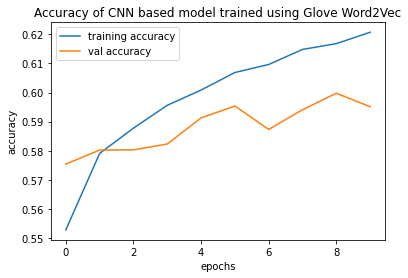

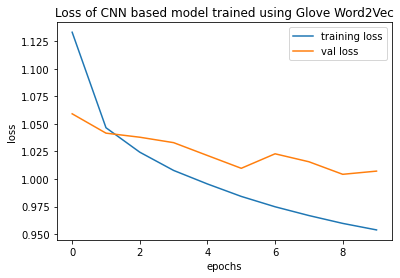

In [50]:
plt.figure(0)
plt.plot(hist_glove.history['accuracy'], label='training accuracy')
plt.plot(hist_glove.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy of CNN based model trained using Glove Word2Vec')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(hist_glove.history['loss'], label='training loss')
plt.plot(hist_glove.history['val_loss'], label='val loss')
plt.title('Loss of CNN based model trained using Glove Word2Vec')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [51]:
test_data = pd.read_table('/Users/debajyotidas/Documents/GitHub/Rotten Tomatoes review Sentiment Analysis/Data/test.tsv.zip',header=None,names=['PhraseId','SentenceId','Phrase'],sep='\t')

In [52]:
test_phrase = tokenizer.texts_to_sequences(test_data['Phrase'])

In [53]:
test_phrase = tf.keras.preprocessing.sequence.pad_sequences(test_phrase,maxlen=max_review_length,padding='pre',truncating='pre')

In [54]:
test_predict = model.predict(test_phrase)

In [55]:
test_predict.shape

(66293, 5)

In [56]:
predictions = []
for val in test_predict:
    predictions.append(np.argmax(val))

In [57]:
phrase_id = test_data['PhraseId'].values

In [58]:
final_answer = pd.DataFrame({'PhraseId':phrase_id,'Sentiment':predictions})

In [59]:
filename = 'RottenTomato_SentiMentAnalysis_output.csv'
final_answer.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: RottenTomato_SentiMentAnalysis_output.csv
